In [1]:
using Pkg
Pkg.develop(path="../../Tambo/")
using Tambo
Pkg.activate(".")

   Resolving package versions...
  No Changes to `~/research/TAMBO-MC/notebooks/differential_sensitivities/Project.toml`
  No Changes to `~/research/TAMBO-MC/notebooks/differential_sensitivities/Manifest.toml`
  Activating project at `~/research/TAMBO-MC/notebooks/differential_sensitivities`


In [2]:
using JLD2
using Glob

# Extrapolate out computed rates to get scaling
using Optim
using CurveFit

# Compute effective area
using FHist
using StatsBase

# interpolate and integrate effective areas
using SmoothingSplines
using QuadGK

# Plotting
using LaTeXStrings
using Makie
using CairoMakie

# QoL
using ProgressBars
include("../../scripts/2_trigger_events/trigger_defs.jl")

corsika_int_weight (generic function with 3 methods)

In [3]:
const year = 365.25 * 24 * 3600 * units.second

4.79359944e22

In [4]:
# jldf = jldopen("/Users/jlazar/Downloads/larger_valley_hard_00000_00001_150_1000.jld2")

In [4]:
sim_example = jldopen("../../ack_scratch/sims/hard_spectrum/larger_valley_00000_00001.jld2")
sim_config = Dict(kv[1]=>kv[2] for kv in sim_example["config"])
# sim_config["geo_spline_path"] = "../resources/tambo_spline.jld2"

injection_config = Dict(
    "thetamin" => rad2deg(sim_config[:θmin]),
    "thetamax" => rad2deg(sim_config[:θmax]),
    "phimin" => rad2deg(sim_config[:ϕmin]),
    "phimax" => rad2deg(sim_config[:ϕmax]),
    "emin" => sim_config[:emin] / units.GeV,
    "emax" => sim_config[:emax] / units.GeV,
    "gamma" => sim_config[:γ],
    "r_injection" => sim_config[:r_injection] / units.m,
    "l_endcap" => sim_config[:l_endcap] / units.m,
    "xs_dir" => "../../resources/cross_sections/tables/",
    "xs_model" => "csms",
    "nu_pdg" => sim_config[:ν_pdg],
    "interaction" => "CC",
)

geo_config = Dict(
    "geo_spline_path" => "../../resources/tambo_spline.jld2",
    "tambo_coordinates" => rad2deg.([sim_config[:tambo_coordinates].latitude, sim_config[:tambo_coordinates].longitude]),
    "plane_orientation" => sim_example["config"][:plane_orientation].proj
)

geo = Tambo.Geometry(geo_config)
plane = Tambo.Plane(normal_vecs.larger_valley, Tambo.coords.larger_valley, geo)
injector = Tambo.Injector(injection_config, geo)

close(sim_example)

In [25]:
edges = 10 .^ LinRange(-0.3, 3, 15) .* units.PeV
cents = (edges[1:end-1] .+ edges[2:end]) ./2
widths = edges[2:end] .- edges[1:end-1]

array_lengths = [200, 300, 400, 500, 600, 750, 800, 900, 1000, 1500, 2000, 2500, 3000, 3500]

nmodules = Int[]
x = ones((length(array_lengths), length(cents), 2))

for (idx, ℓ) in ProgressBar(enumerate(array_lengths))
    
    fs = glob("larger_valley_hard_00000_000??_150_$(ℓ).jld2", "/Users/jlazar/Downloads/")
    
    triggered_events = Tambo.InjectionEvent[]
    nmodule = nothing
    nevent = 0
    
    for f in fs
        
        jldf = jldopen(f)
        
        if typeof(nmodule)==Nothing
            nmodule = length(Tambo.make_detector_array(
                jldf["array_config"]["length"],
                jldf["array_config"]["deltas"],
                jldf["array_config"]["altmin"],
                jldf["array_config"]["altmax"],
                plane,
                geo,
                Tambo.SVector{3}(1,2,1)
            ))
        end
        subsimset = split(f, "_")[end-2]
        sim = jldopen("../../ack_scratch/sims/larger_valley_00000_$(subsimset).jld2")

        nevent += sim["config"][:n]

        hit_maps = jldf["hit_map"]
        triggered_idxs = Int[]
        for k in keys(hit_maps)
            v = hit_maps[k]
            if did_trigger(v)
                push!(triggered_idxs, parse(Int, k))
            end

        end
        triggered_events = vcat(triggered_events, sim["injected_events"][triggered_idxs])
    end
    es = map(x->x.initial_state.energy, triggered_events)
    oneweights = Tambo.oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ nevent
    wgts = Weights(oneweights)
    h = Hist1D(es, wgts, edges)
    x[idx, :, 1] = h.hist.weights ./ widths
    # TODO Compute the δ
    push!(nmodules, nmodule)
end

length(triggered_events) = 713

0.0%┣                                               ┫ 0/14 [00:00<00:00, -0s/it]



length(triggered_events) = 970

7.1%┣███                                        ┫ 1/14 [00:11<Inf:Inf, InfGs/it]



length(triggered_events) = 1149

14.3%┣██████▋                                       ┫ 2/14 [00:21<04:13, 21s/it]



length(triggered_events) = 1148

21.4%┣█████████▉                                    ┫ 3/14 [00:32<02:56, 16s/it]



length(triggered_events) = 1355

28.6%┣█████████████▏                                ┫ 4/14 [00:43<02:25, 14s/it]



length(triggered_events) = 1559

35.7%┣████████████████▍                             ┫ 5/14 [00:55<02:04, 14s/it]



length(triggered_events) = 1748

42.9%┣███████████████████▊                          ┫ 6/14 [01:08<01:49, 14s/it]



length(triggered_events) = 1736

50.0%┣███████████████████████                       ┫ 7/14 [01:21<01:34, 13s/it]



length(triggered_events) = 1943

57.1%┣██████████████████████████▎                   ┫ 8/14 [01:33<01:20, 13s/it]



length(triggered_events) = 2639

64.3%┣█████████████████████████████▋                ┫ 9/14 [01:46<01:06, 13s/it]



length(triggered_events) = 3358

71.4%┣████████████████████████████████▏            ┫ 10/14 [02:00<00:53, 13s/it]



length(triggered_events) = 4042

78.6%┣███████████████████████████████████▍         ┫ 11/14 [02:16<00:41, 14s/it]



length(triggered_events) = 4712

85.7%┣██████████████████████████████████████▋      ┫ 12/14 [02:33<00:28, 14s/it]



length(triggered_events) = 5107

92.9%┣█████████████████████████████████████████▉   ┫ 13/14 [02:51<00:14, 14s/it]


100.0%┣████████████████████████████████████████████┫ 14/14 [03:12<00:00, 15s/it]
100.0%┣████████████████████████████████████████████┫ 14/14 [03:12<00:00, 15s/it]


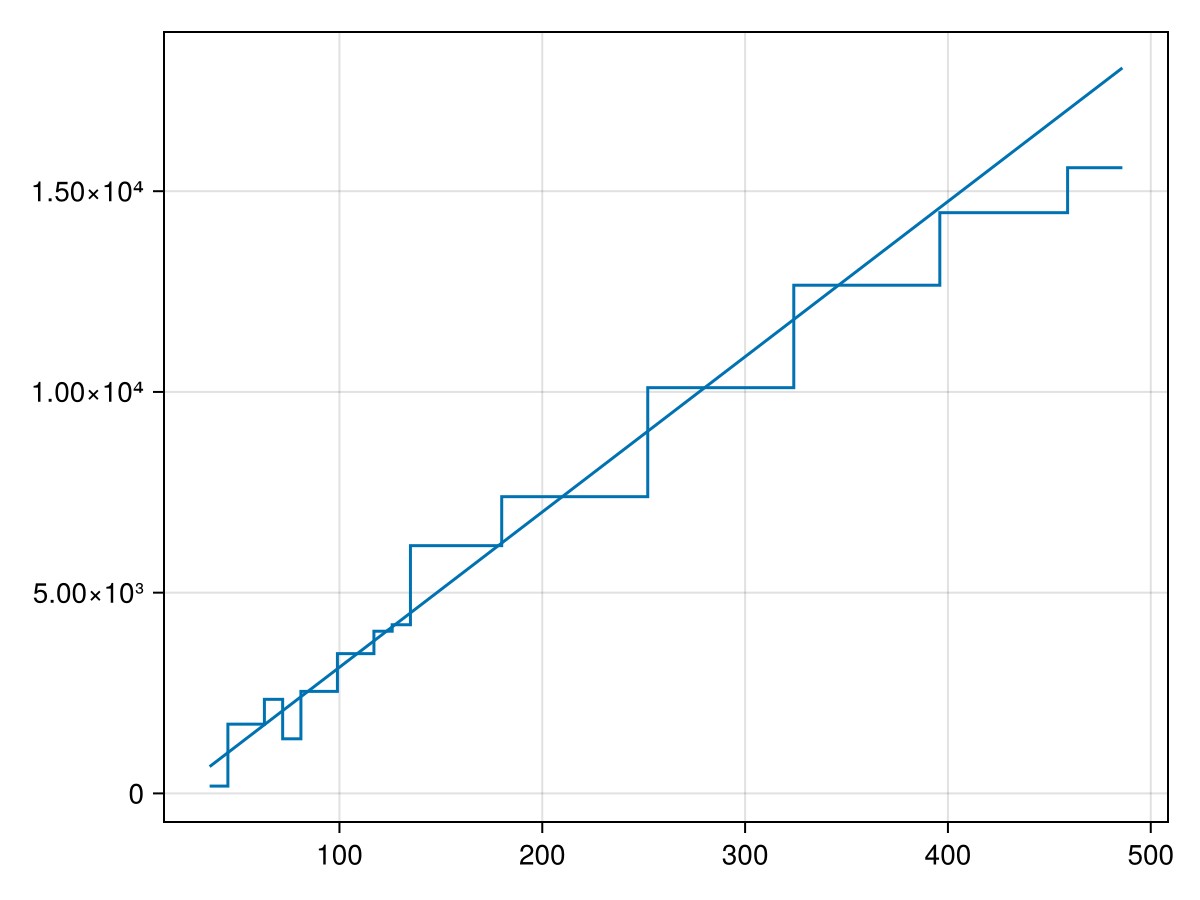

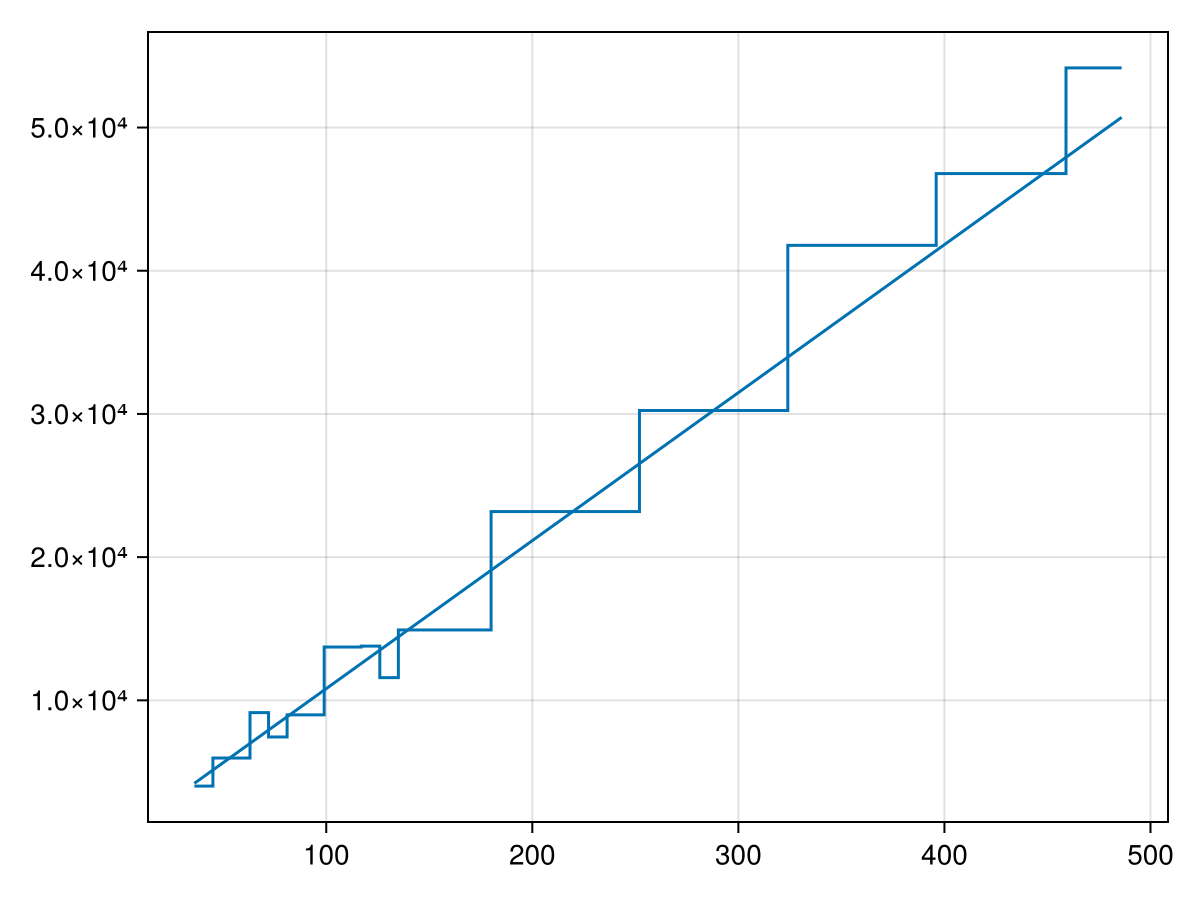

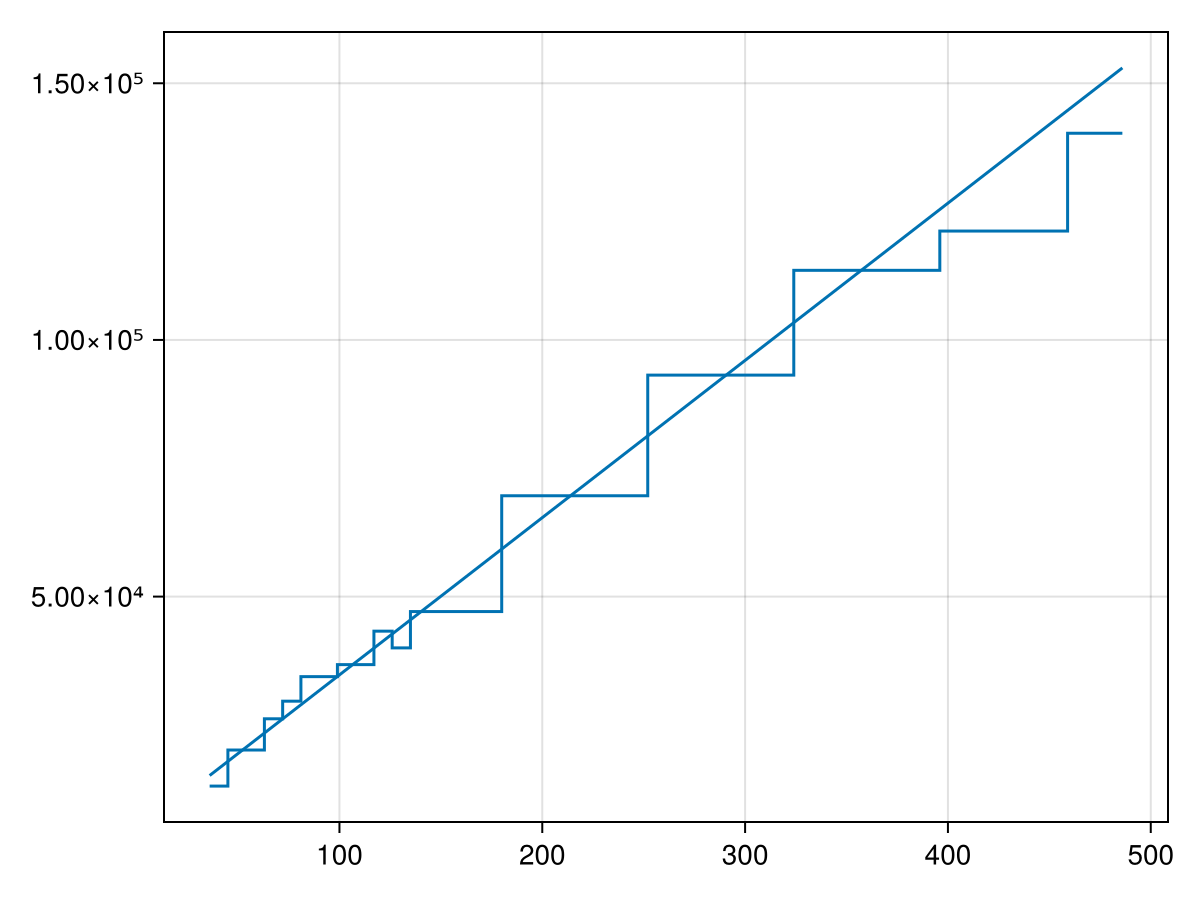

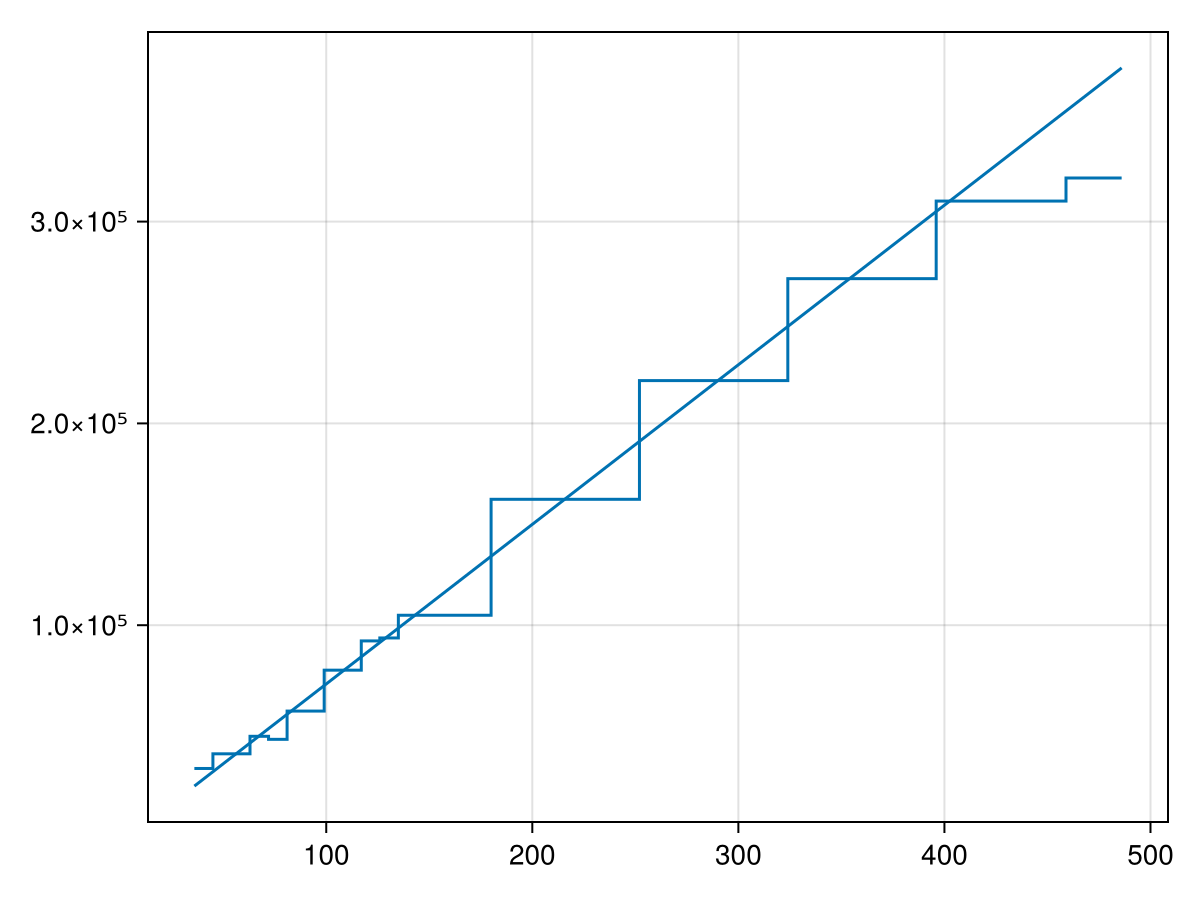

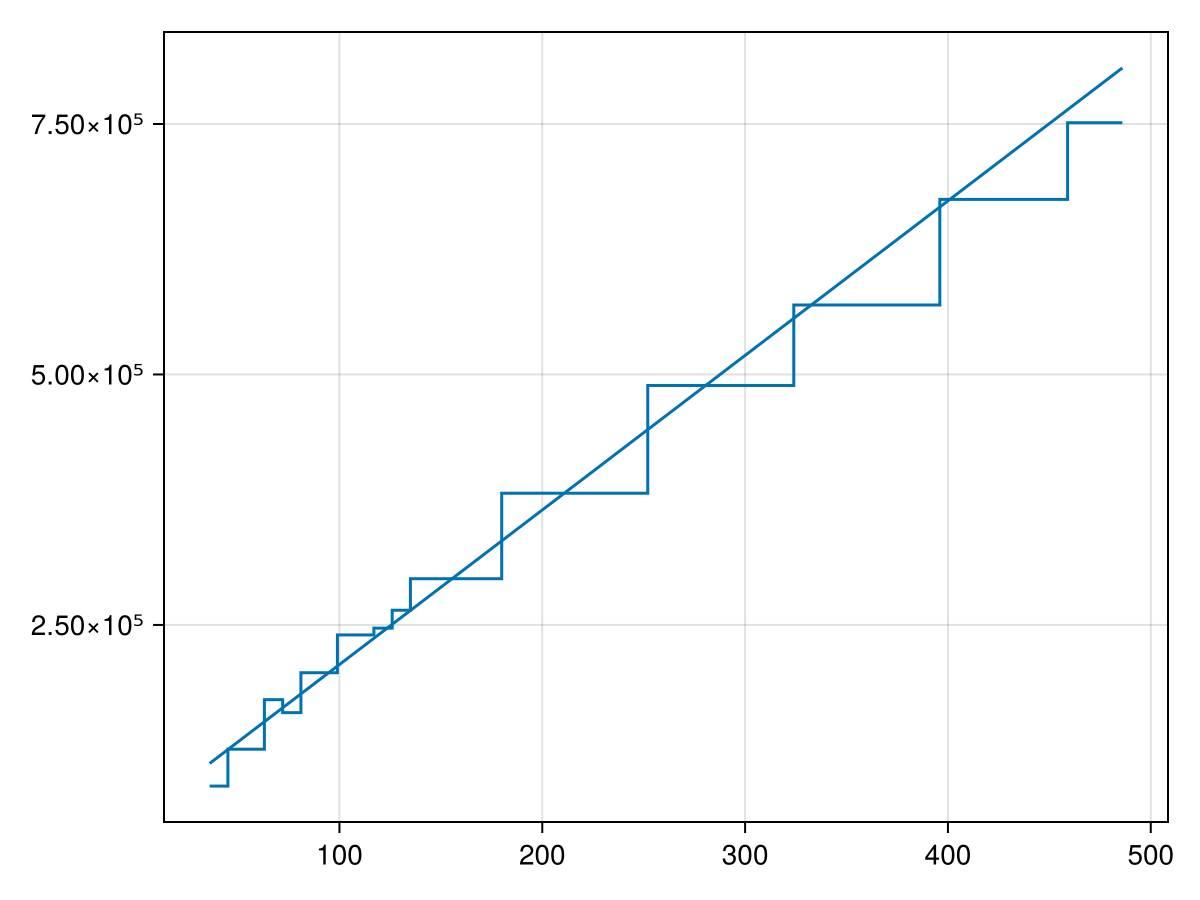

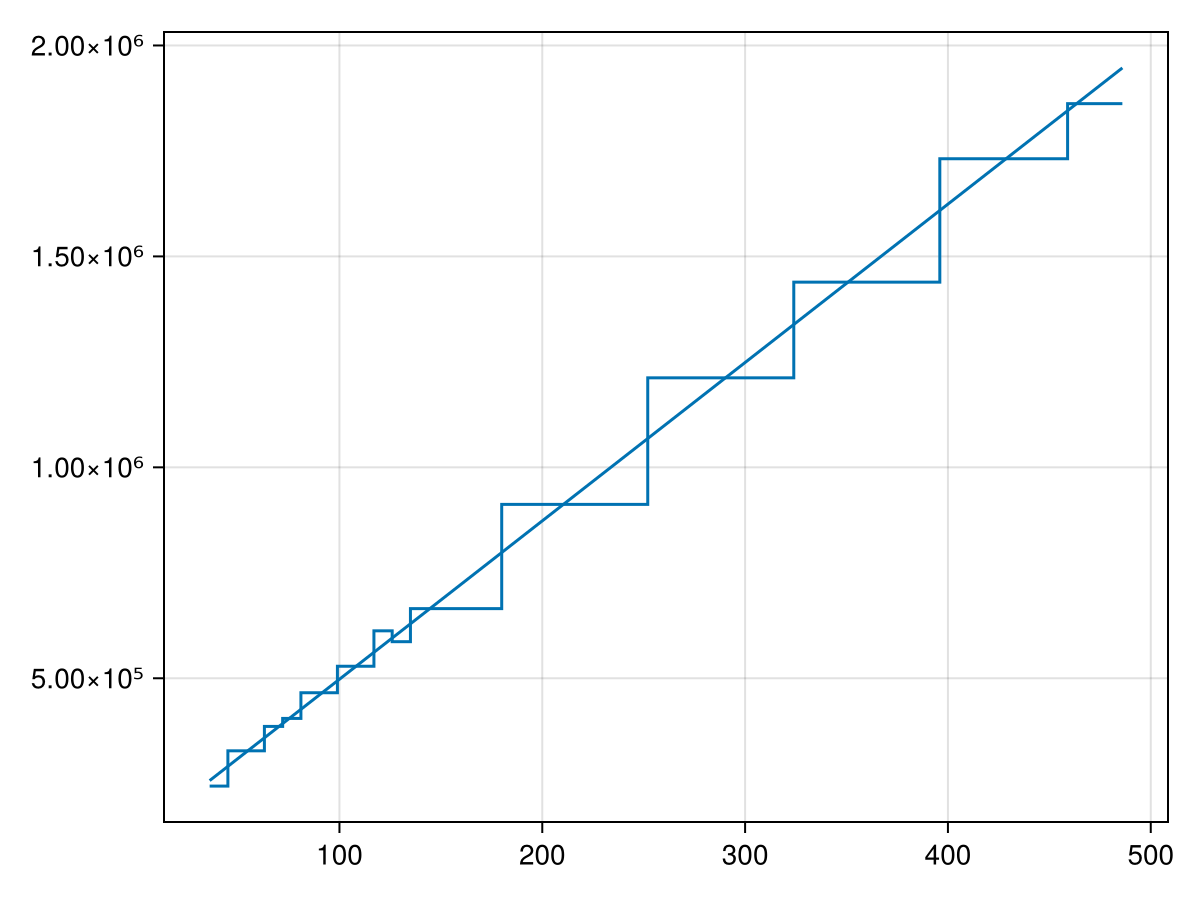

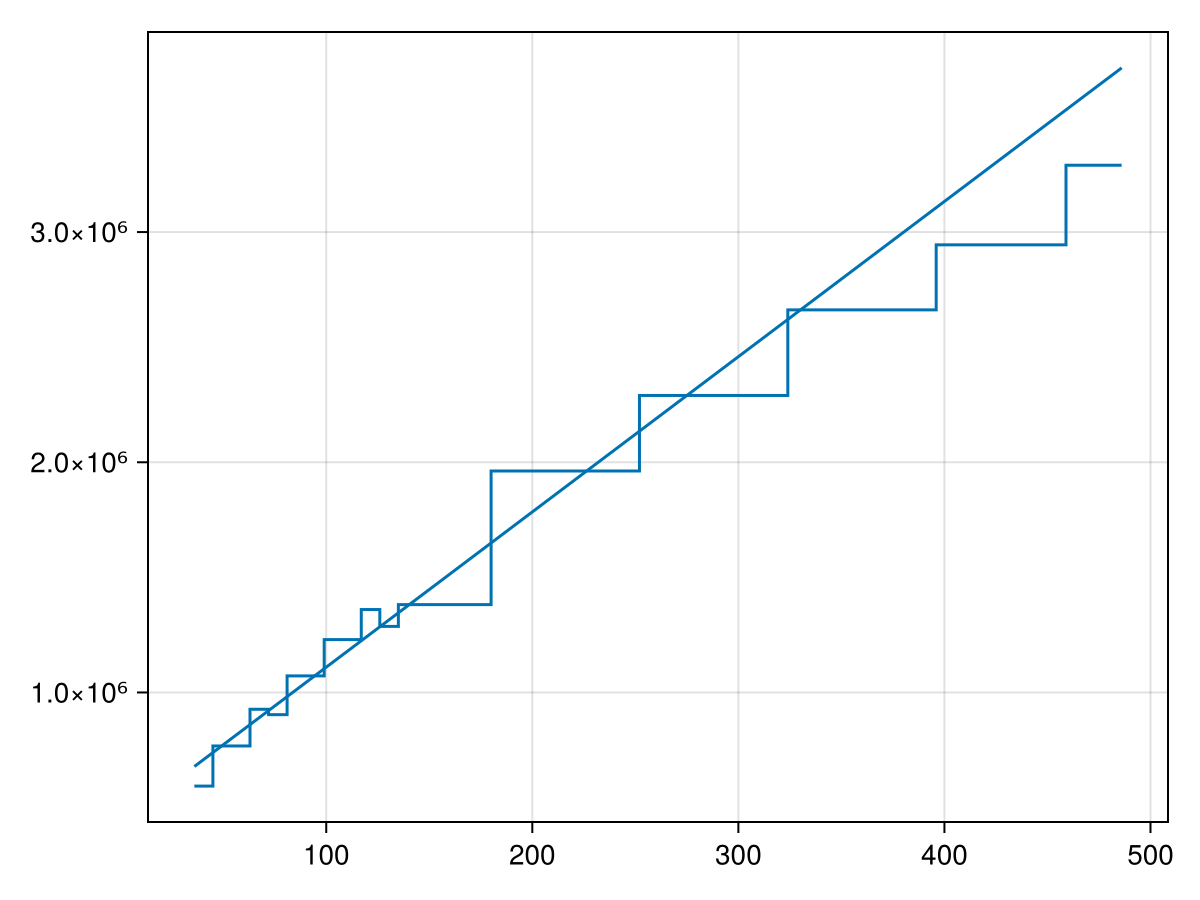

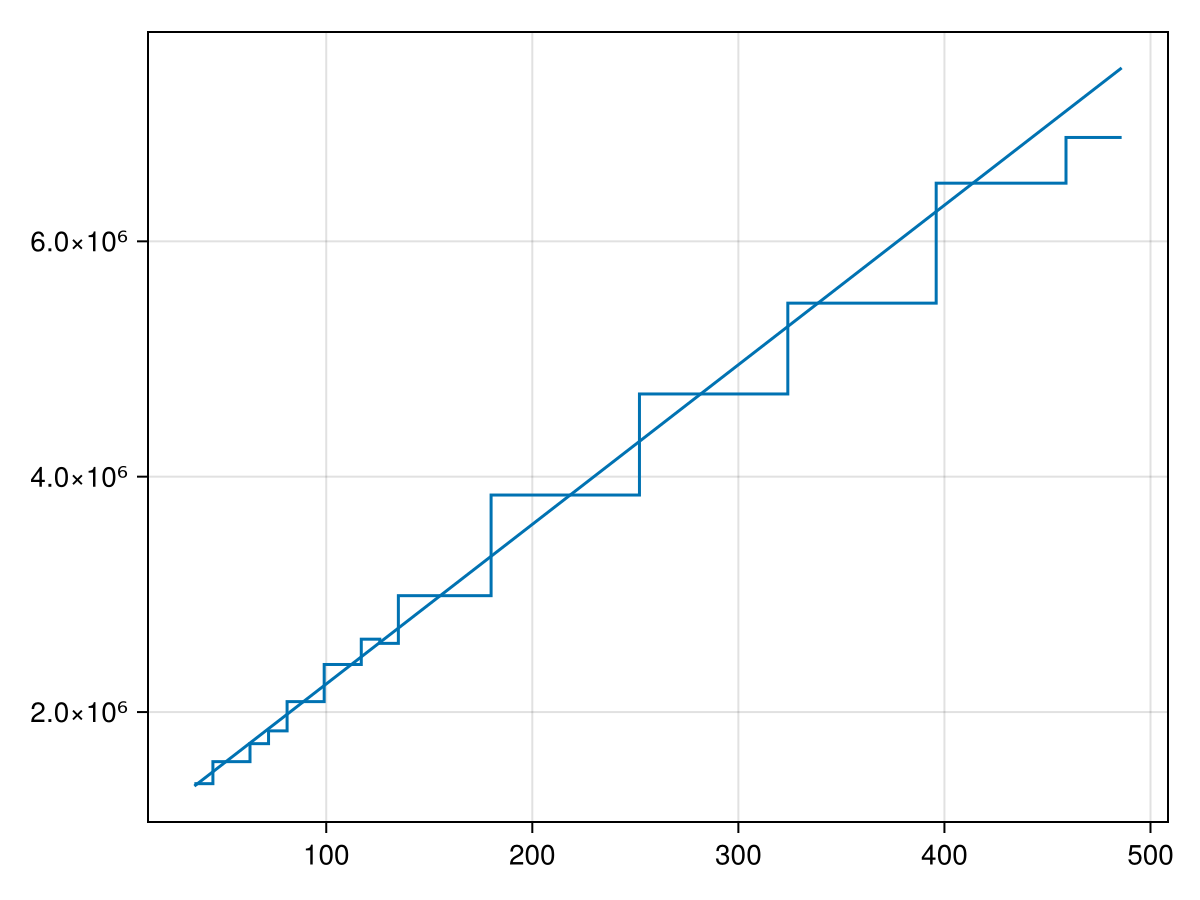

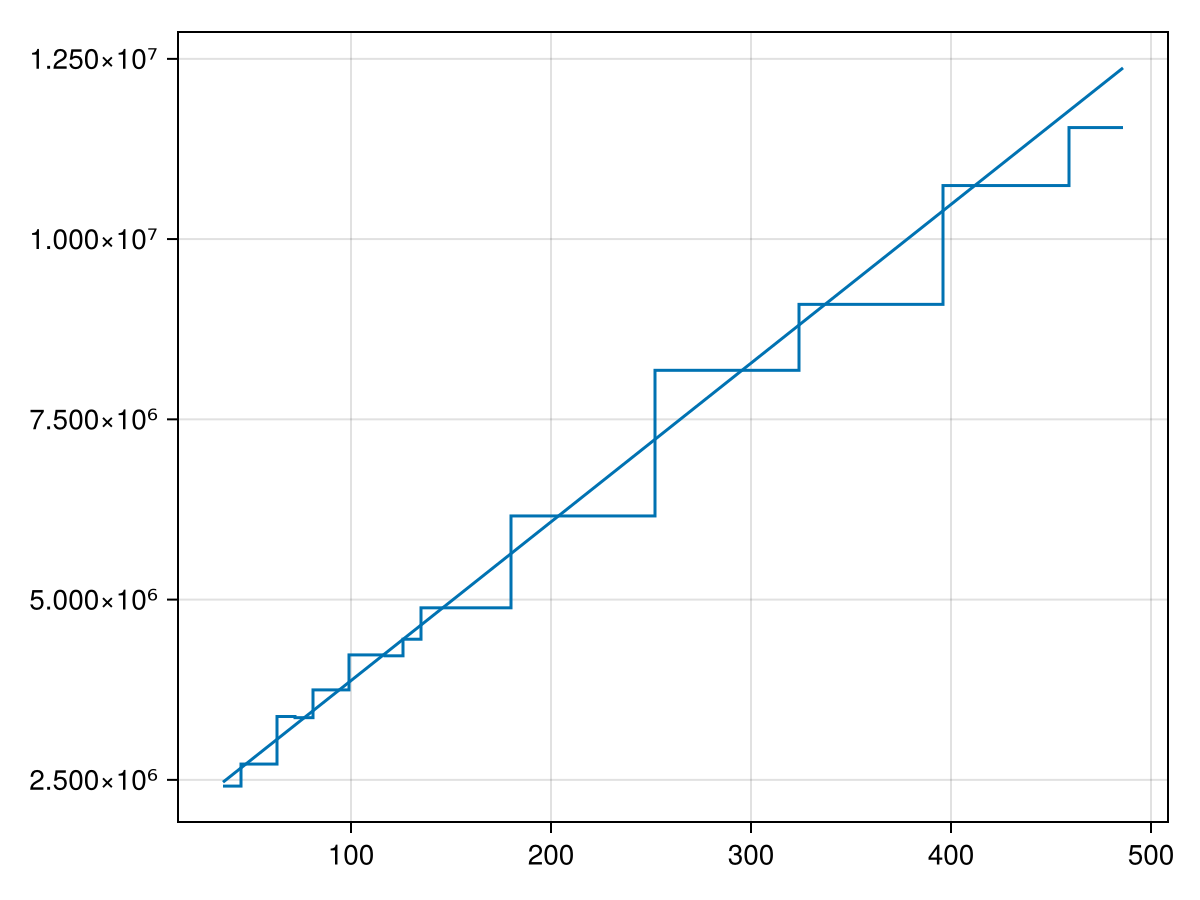

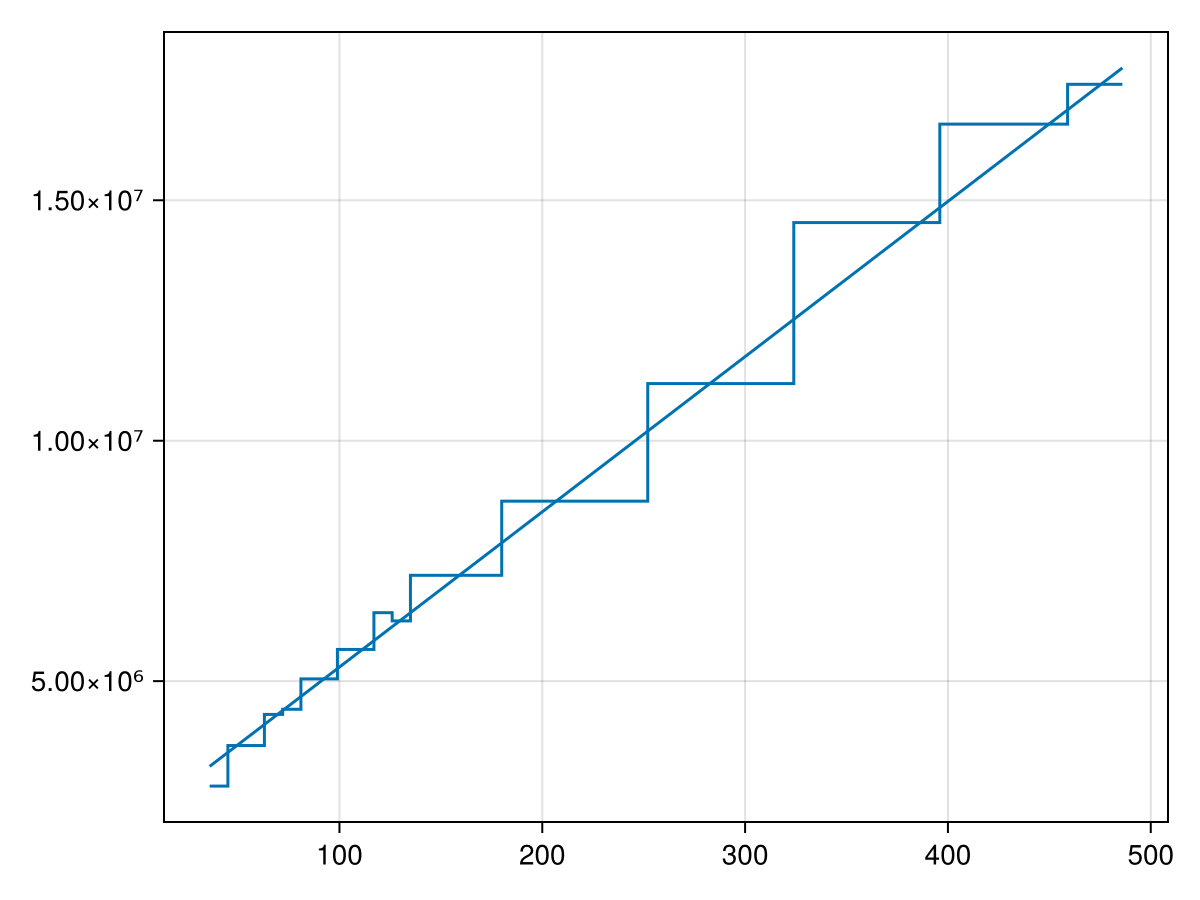

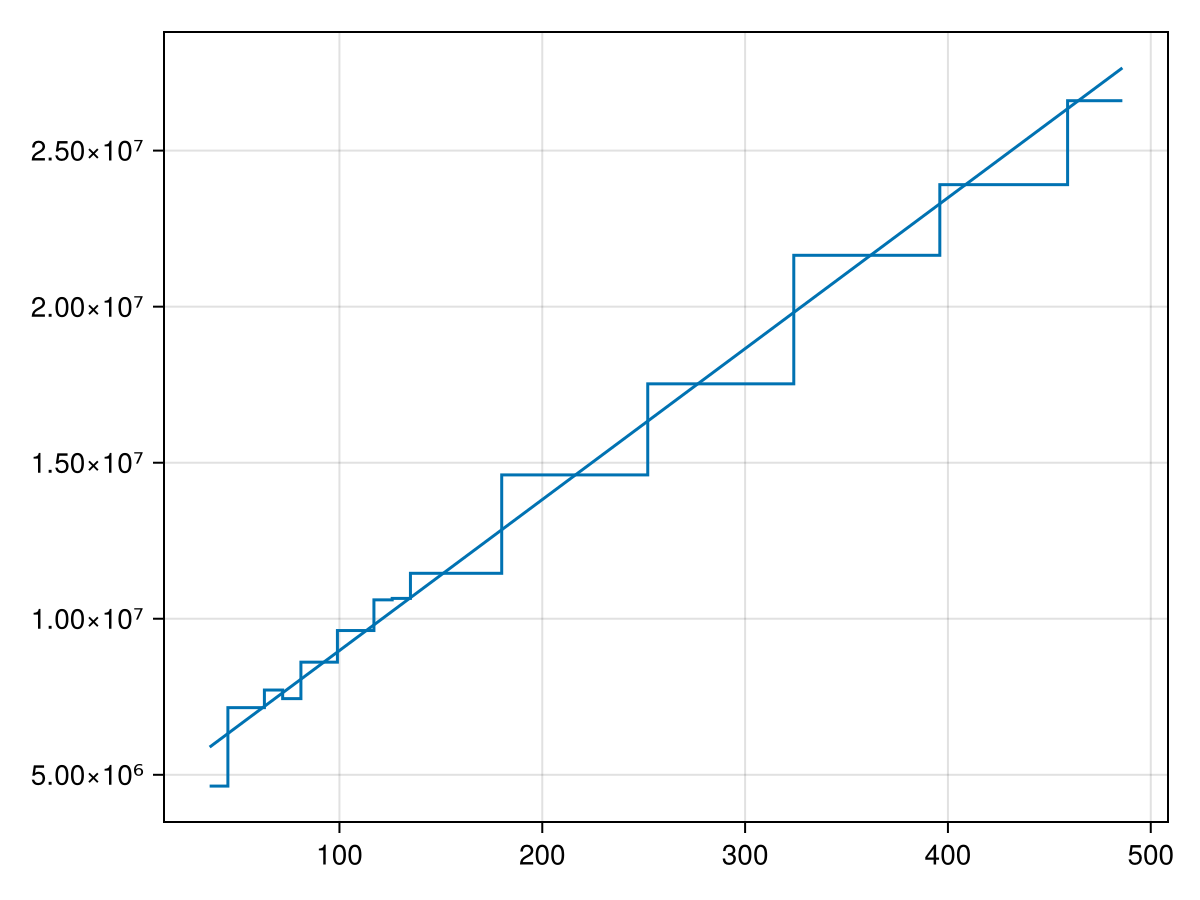

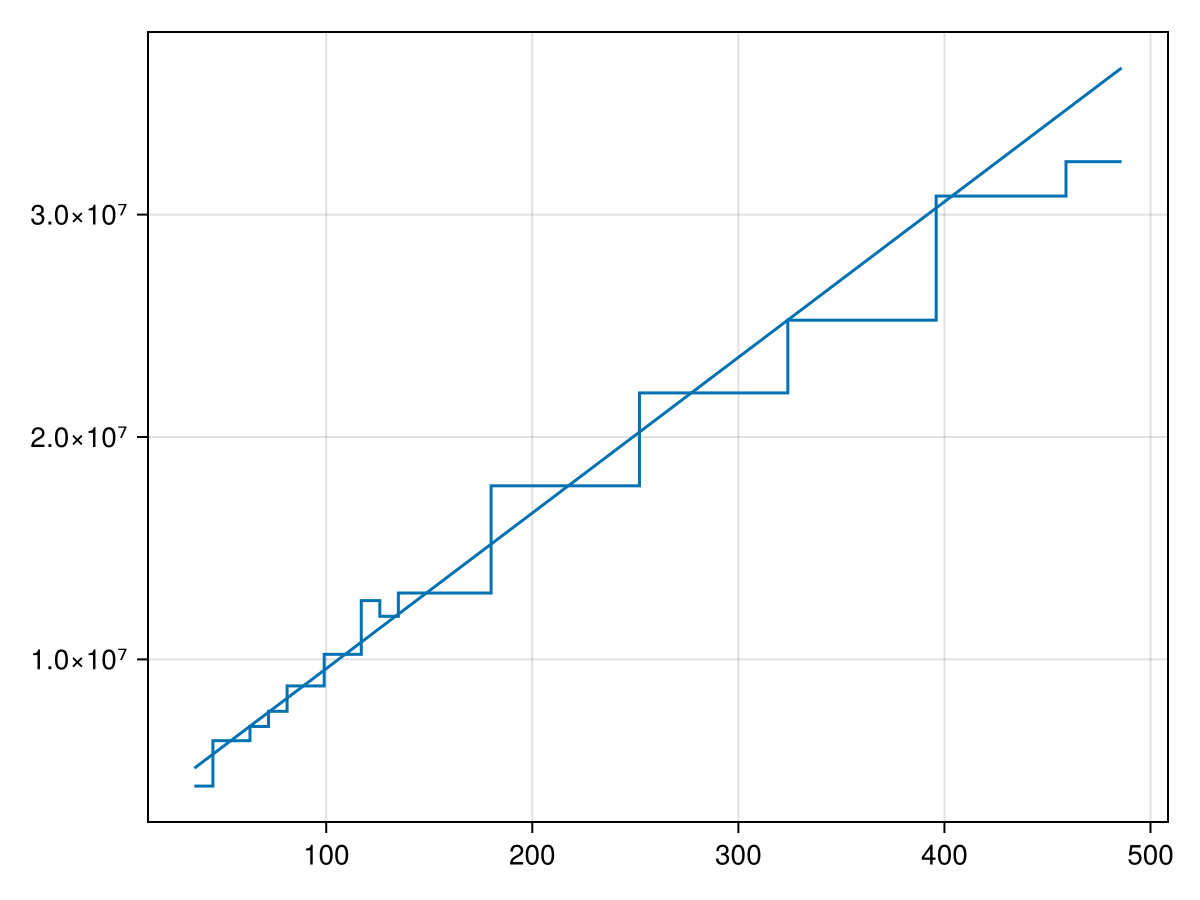

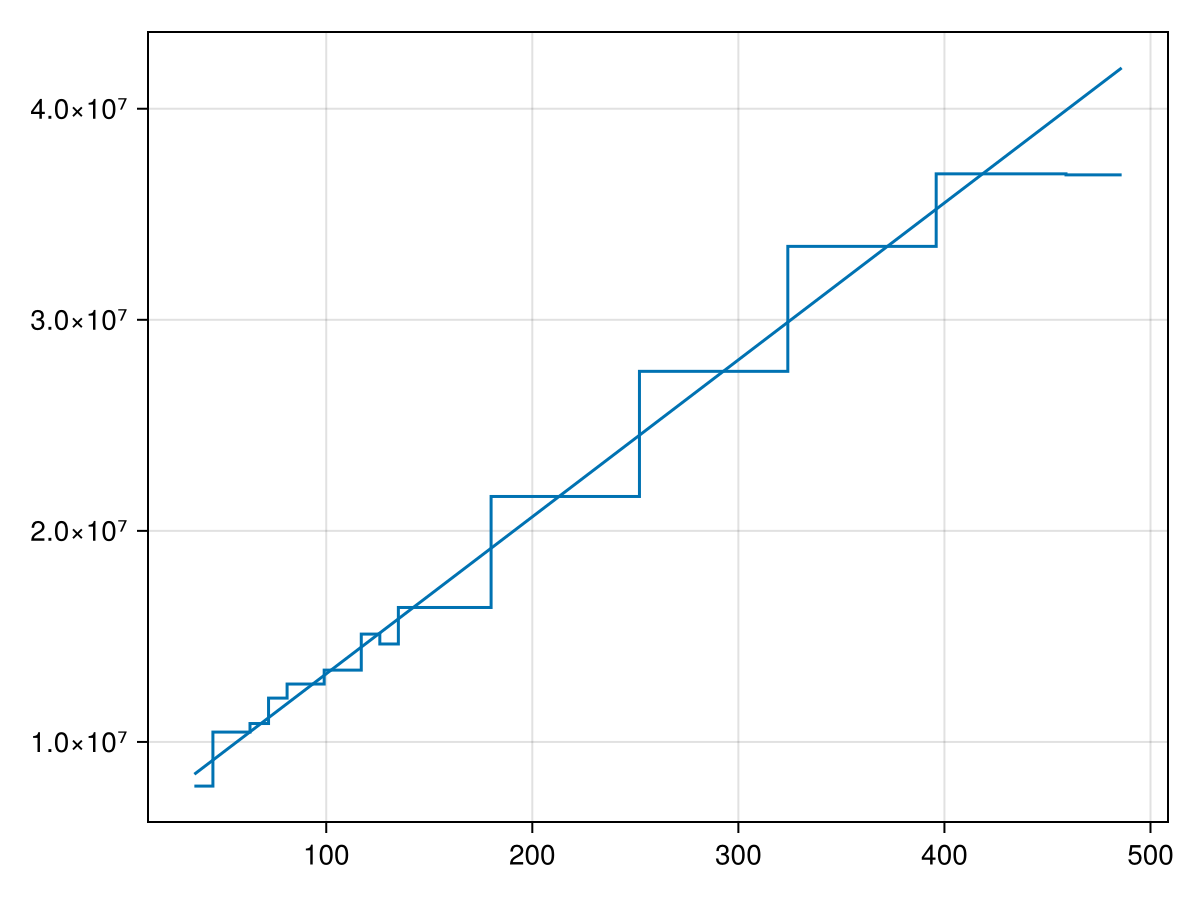

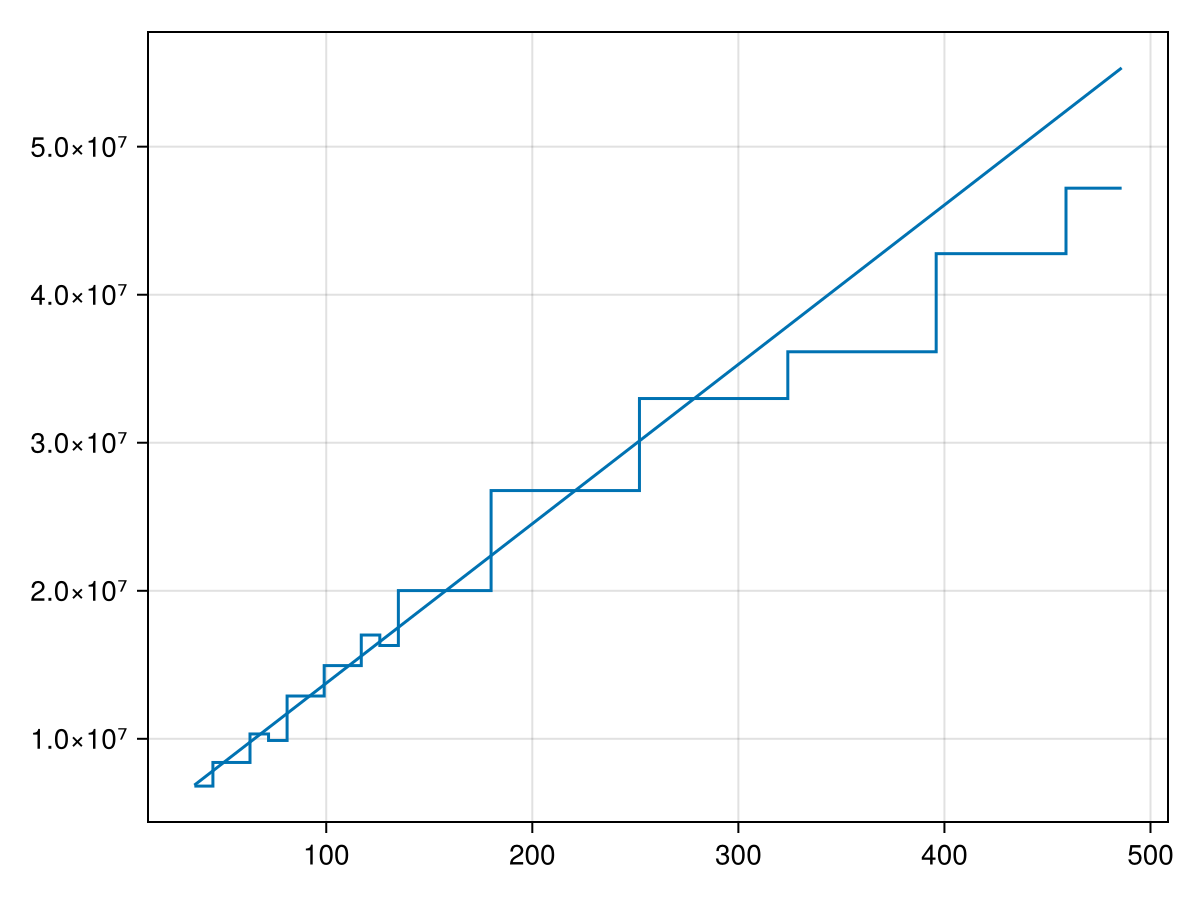

In [26]:
effectivearea_Ω = Float64[]

for idx in 1:size(x)[1]
    fig = Figure()
    ax = Axis(fig[1,1])
    stairs!(ax, nmodules, x[:, idx, 1] ./ units.cm^2, step=:center)
    
    b, m = linear_fit(nmodules[1:end-3], x[1:end-3, idx, 1])
    lines!(ax, nmodules, (m .* nmodules .+ b) ./ units.cm^2)
    display(fig)
    push!(effectivearea_Ω, m * 5000 + b)
end

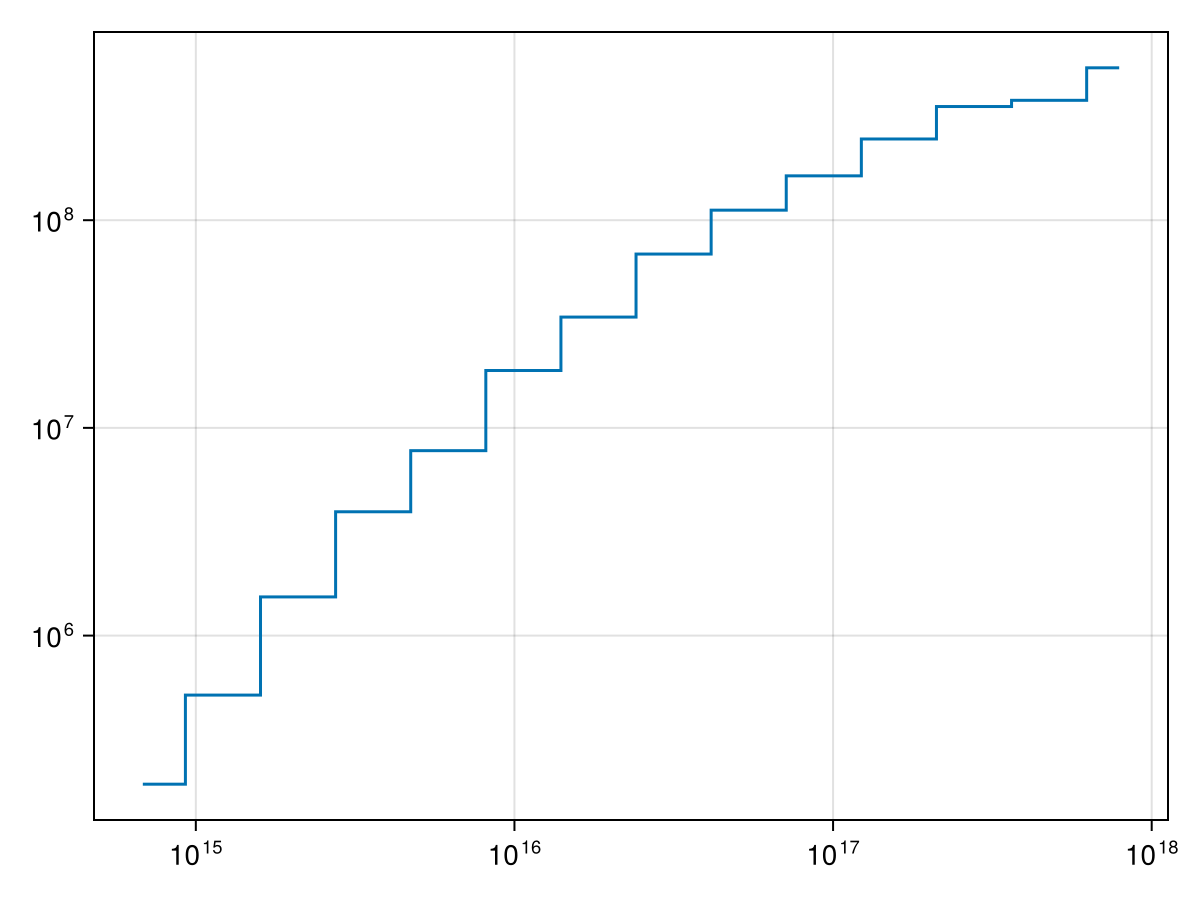

In [27]:
fig = Figure()
ax = Axis(fig[1, 1], xscale=log10, yscale=log10)
stairs!(ax, cents, effectivearea_Ω ./ units.cm^2, step=:center)

fig

In [34]:
function g(p, n, y, δy)
    m, b = p
    yp = m .* n .+ b
    return sum((yp .- y) .^ 2 ./ δy .^ 2)
end

g (generic function with 2 methods)

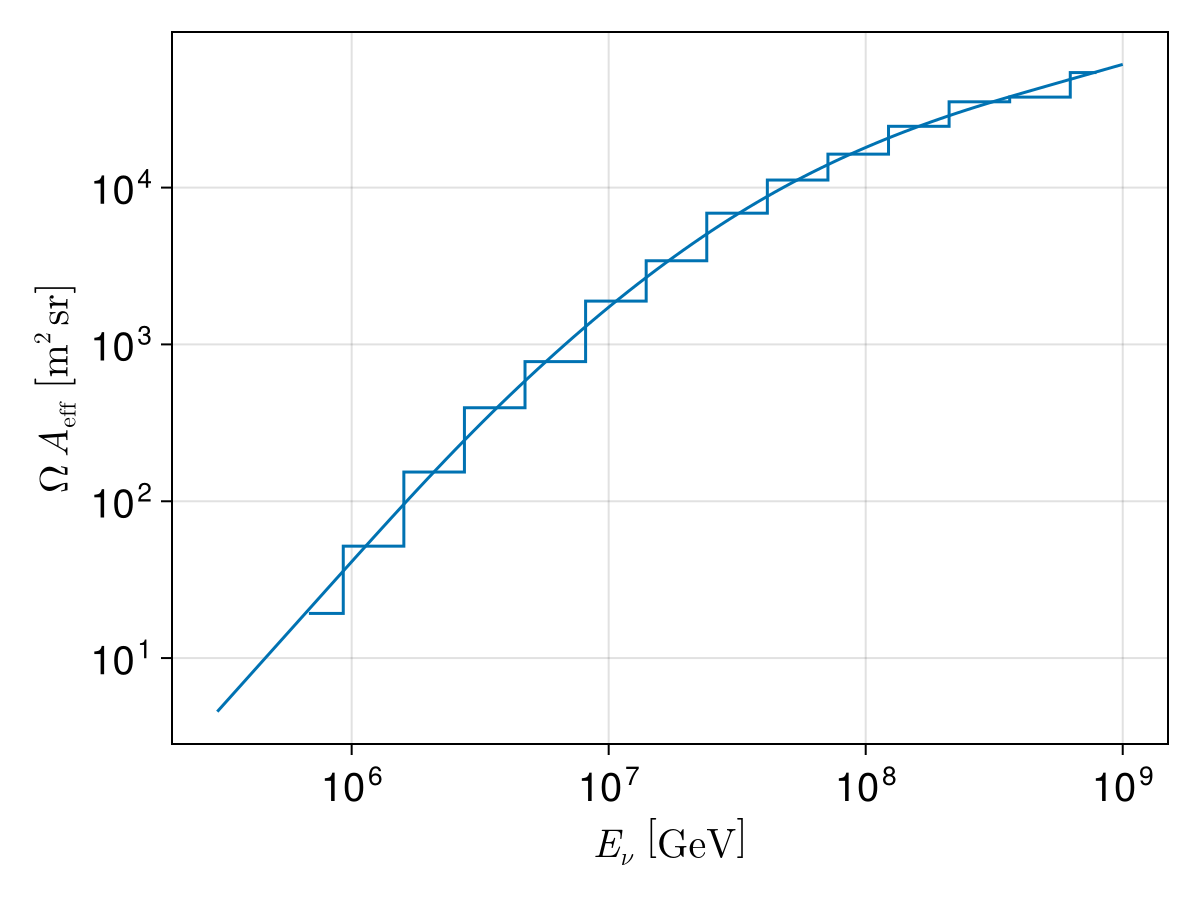

In [37]:
spl = SmoothingSplines.fit(
    SmoothingSpline,
    log.(cents),
    log.(effectivearea_Ω),
    0.5
)

fine_es = (10 .^ LinRange(log(10, 0.3), 3, 100)) .* units.PeV
interped_effa = exp.(predict.(Ref(spl), log.(fine_es)))

fig = Figure(fontsize=20)

ax = Axis(
    fig[1, 1],
    xscale=log10,
    yscale=log10,
    xlabel=L"E_{\nu}~\left[\mathrm{GeV}\right]",
    ylabel=L"\Omega\, A_{\mathrm{eff}}~\left[\mathrm{m}^{2}\,\mathrm{sr}\right]"
)

stairs!(
    ax,
    cents ./ units.GeV,
    effectivearea_Ω ./ units.m^2,
    step=:center
)

lines!(ax, fine_es ./ units.GeV, interped_effa / units.m^2, fine_es)

fig

In [38]:
pavel_norms = [1.8995052121226763e-19, 6.269206947352916e-21, 3.2297181355164026e-22, 1.9772329206625328e-23, 1.6327753266356979e-24, 1.9077918937306844e-25, 3.064665871092821e-26, 9.073827181711629e-27]
pavel_cents = 10 .^ (14.5:0.5:18)

8-element Vector{Float64}:
 3.1622776601683794e14
 1.0e15
 3.1622776601683795e15
 1.0e16
 3.162277660168379e16
 1.0e17
 3.1622776601683795e17
 1.0e18

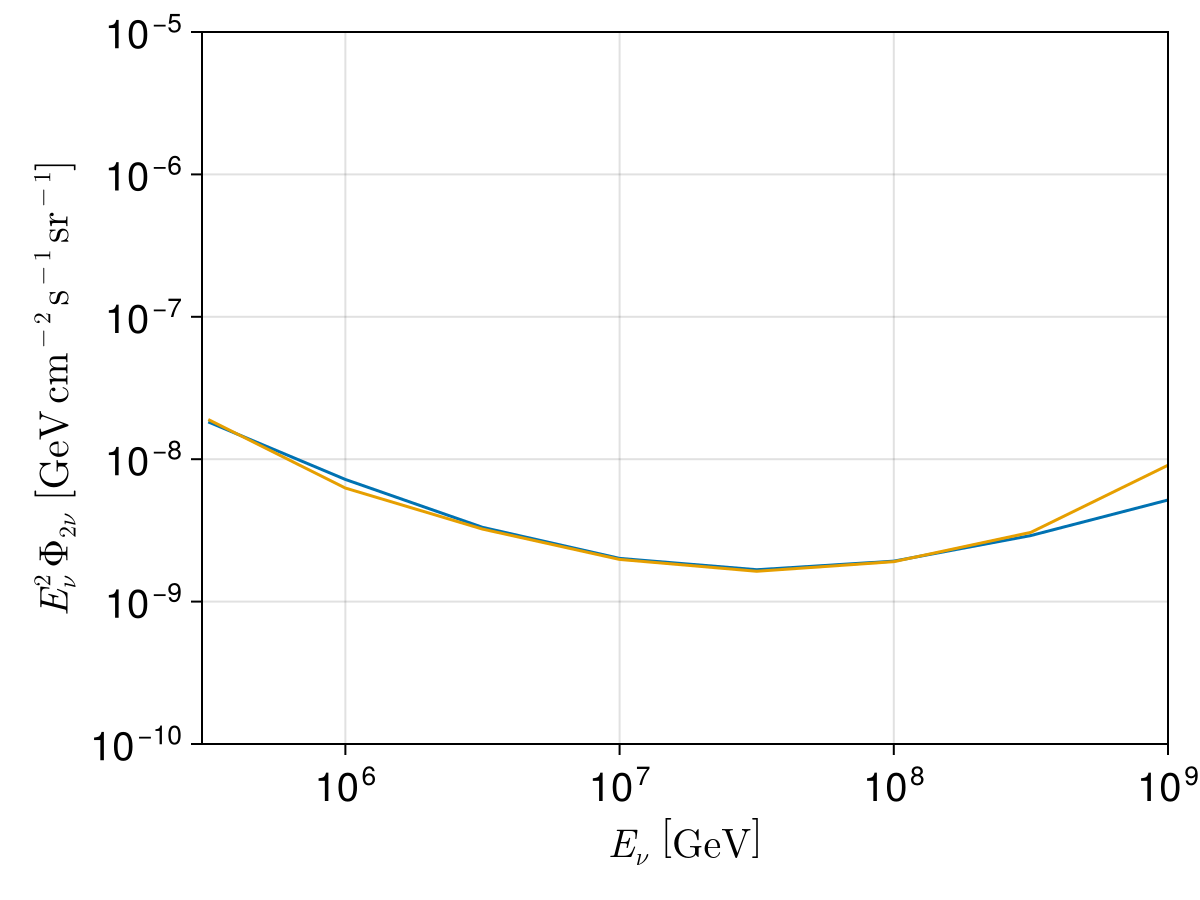

CairoMakie.Screen{IMAGE}


In [39]:
γ = 2
norm0 = 1.0e-1
norms = Float64[]

for ecent in pavel_cents
    emin = ecent / 10^0.5
    emax = ecent * 10^0.5
    base_norm = norm0 / units.GeV / units.cm^2 / units.second * (1 /(ecent))^-γ
    
    Φ = Tambo.PowerLaw(γ, 1000units.GeV, 1e9units.GeV, base_norm)
    f(e) = Φ(e) * exp(predict(spl, log(e))) * 10 * year
    g(le) = exp(le) * f(exp(le))

    I, err = quadgk(g, log(emin), log(emax))
    if err / I > 1e-5
        error()
    end
    push!(norms, 2.44 * norm0 / I)
end

fig = Figure(fontsize=20)

ax = Axis(
    fig[1, 1],
    xscale=log10,
    yscale=log10,
    limits=(3e5, 1e9, 1e-10, 1e-5),
    xlabel=L"E_{\nu}~\left[\mathrm{GeV}\right]",
    ylabel=L"E_{\nu}^{2}\,\Phi_{2\nu}~\left[\mathrm{GeV}\,\mathrm{cm}^{-2}\,\mathrm{s}^{-1}\,\mathrm{sr}^{-1}\right]"
)

lines!(ax, pavel_cents / units.GeV, norms .* (pavel_cents ./ units.GeV).^2)
lines!(ax, pavel_cents / units.GeV, pavel_norms .* (pavel_cents ./ units.GeV).^2)

display(fig)